# Setup

In [1]:
# Clone Albat repository
!cd /content
!git clone https://github.com/williamsdaniel888/Albat.git
# Install and patch Transformers, JRE, JDK
!sudo bash /content/Albat/script/setup.sh
# Load other package dependencies
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"     #set environment variable
import json
import sklearn.metrics
import numpy as np
from pprint import pprint
import datetime

Cloning into 'Albat'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 334 (delta 81), reused 142 (delta 53), pack-reused 153
Receiving objects: 100% (334/334), 23.05 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (146/146), done.
     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 890kB 11.7MB/s 
     |████████████████████████████████| 3.0MB 18.0MB/s 
     |████████████████████████████████| 1.1MB 32.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=aa350e26dadd418e85f434c7996a269e2d8ef7f7156e35eba540ea2a41f7932b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  ca-c

#Adversarial Training
Run the fine-tuning script: 

```
run_absa_traineval.sh [task] [pt model] [dataset] pt_[task] [runs] [epochs] [gpu_id]
```
Where
- `task` is one of `e2e`, `ae`, `asc`;
- `pt model` is the folder containing pre-trained Albert model files (reserved for future use, temporarily set to `albat_pt_1`);
- `dataset` is one of `laptop`, `rest`, `mams`, `unified`;
- `runs` is an integer indicating how many times should a new model be instantiated and fine-tuned (using a different seed each time);
- `epochs` is an integer indicating the number of epochs for fine-tuning;
- `gpu_id` is typically equal to 0.




In [2]:
%cd /content/Albat/script

runs = 1    # the number of distinct models to fine-tune
epochs = 1  # the number of fine-tuning epochs
gpu_id = 0  # the GPU to use for fine-tuning

# E2E Training and Evaluation
print(datetime.datetime.now())
!bash run_absa_traineval.sh e2e albat_pt_1 laptop pt_e2e $runs $epochs $gpu_id
print(datetime.datetime.now())
!bash run_absa_traineval.sh e2e albat_pt_1 rest pt_e2e $runs $epochs $gpu_id
print(datetime.datetime.now())
!bash run_absa_traineval.sh e2e albat_pt_1 unified pt_e2e $runs $epochs $gpu_id
print(datetime.datetime.now())
!bash run_absa_traineval.sh e2e albat_pt_1 mams pt_e2e $runs $epochs $gpu_id 
print(datetime.datetime.now())

# AE Training and Evaluation
print(datetime.datetime.now())
!bash run_absa_traineval.sh ae albat_pt_1 laptop pt_ae $runs $epochs $gpu_id
print(datetime.datetime.now())
!bash run_absa_traineval.sh ae albat_pt_1 rest pt_ae $runs $epochs $gpu_id

# AE Training and Evaluation
print(datetime.datetime.now())
!bash run_absa_traineval.sh asc albat_pt_1 laptop pt_asc $runs $epochs $gpu_id 
print(datetime.datetime.now())
!bash run_absa_traineval.sh asc albat_pt_1 rest pt_asc $runs $epochs $gpu_id
print(datetime.datetime.now())

/content/Albat/script
2020-08-21 12:08:02.035471
using cuda0
using pytorch 1.6.0+cu101
Run 1
2020-08-21 12:10:07.735663


#Evaluation

In [6]:
def evaluate(tasks, berts, domains, runs=10):
    for task in tasks:
        for bert in berts:
            for domain in domains:            
                scores=[]
                for run in range(1, runs+1):
                    DATA_DIR=os.path.join(task, domain)
                    OUTPUT_DIR=os.path.join("run", bert+"_"+task, domain, str(run) )
                    if os.path.exists(os.path.join(OUTPUT_DIR, "predictions.json") ):
                        if  "ae" in task:
                            ret=!python eval/evaluate_ae.py --pred_json $OUTPUT_DIR/predictions.json
                            scores.append(float(ret[0])*100 )
                        elif "asc" in task:
                            with open(os.path.join(OUTPUT_DIR, "predictions.json") ) as f:
                                results=json.load(f)
                            y_true=results['label_ids']
                            y_pred=[np.argmax(logit) for logit in results['logits'] ]
                            p_macro, r_macro, f_macro, _=sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
                            f_macro = 2*p_macro*r_macro/(p_macro+r_macro)
                            scores.append([100*sklearn.metrics.accuracy_score(y_true, y_pred), 100*f_macro ] )
                        elif "e2e" in task:
                            with open(os.path.join(OUTPUT_DIR, "predictions.json") ) as f:
                                results=json.load(f)
                            y_true = []
                            y_pred = []
                            for i,e in enumerate(results['label_ids']):
                                sidx = e[1:].index(-1)
                                y_true += e[1:sidx]
                                logits = results['logits'][i][1:sidx]
                                y_pred += [np.argmax(logit) for logit in logits]
                            p_macro, r_macro, f_macro, _=sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)
                            f_macro = 2*p_macro*r_macro/(p_macro+r_macro)
                            scores.append([100*sklearn.metrics.accuracy_score(y_true, y_pred), 100*f_macro] )
                        else:
                            raise Exception("unknown task")
                scores=np.array(scores)
                m=scores.mean(axis=0)
                
                if len(scores.shape)>1:
                    mts = ["ACC","MF1"]
                    print("")
                    for iz, score in enumerate(m):
                        print(task, ":", domain, "metric", mts[iz], round(score, 2), "({:.2f})".format(scores[:,iz].max()))
                    print("")
                else:
                    print(task, ":", domain, " metric F1 ",  round(m,2),'\n')               

## Metric Evaluation
Here we evaluate:
- Accuracy and macro-averaged F1 score for **E2E-ABSA** with Lapt14, Rest14, MAMS, Unified
- F1 Score for **AE** with Lapt14 and Rest14
- Accuracy and macro-averaged F1 score for **ASC** with Lapt14 and Rest14

In [7]:
%cd /content/Albat
print('')
tasks=["e2e"]
berts=["pt"]
domains=["unified","mams"]
runs=5
evaluate(tasks, berts, domains, runs)
tasks=["e2e","asc","ae"]
berts=["pt"]
domains=["laptop","rest"]
runs=5
evaluate(tasks, berts, domains, runs)

/content/Albat


e2e : unified metric ACC 92.95 (92.95)
e2e : unified metric MF1 38.7 (38.70)


e2e : mams metric ACC 90.36 (90.36)
e2e : mams metric MF1 45.78 (45.78)


e2e : laptop metric ACC 91.81 (91.81)
e2e : laptop metric MF1 28.81 (28.81)


e2e : rest metric ACC 91.93 (91.93)
e2e : rest metric MF1 35.67 (35.67)


asc : laptop metric ACC 75.71 (75.71)
asc : laptop metric MF1 73.91 (73.91)


asc : rest metric ACC 80.45 (80.45)
asc : rest metric MF1 71.56 (71.56)

ae : laptop  metric F1  71.38 

ae : rest  metric F1  65.79 



## Case Study with Confusion Matrix
The following cell can be used to display a sample sentence from one of the four datasets' test examples and the corresponding predictions from the fine-tuned Albat model. A confusion matrix for the chosen example is also displayed for convenient error analysis.

/content/Albat/src
EXAMPLE #0

Color key:
Non-aspect word: [black on white]
Positive:  beginning, inside.
Negative:  beginning, inside.
Neutral:   beginning, inside.
Conflict:  beginning, inside.

True labeling scheme:

▁boot▁time▁is▁super▁fast▁,▁around▁anywhere▁from▁35▁seconds▁to
▁1▁minute▁.

Labels predicted by Albat:

▁boot▁time▁is▁super▁fast▁,▁around▁anywhere▁from▁35▁seconds▁to
▁1▁minute▁.

CONFUSION MATRIX:


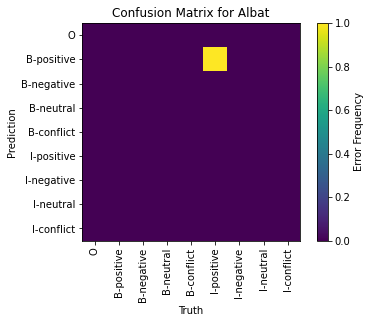

In [8]:
%cd /content/Albat/src
import annotator

# File path for Albat's E2E test set predictions (predictions.json).
# The dataset must be one of {laptop, rest, mams, unified}.
predictions = "/content/Albat/run/pt_e2e/laptop/1/predictions.json"

# Directory path containing ground truth labels for test set (test.json).
# Make sure this is the same dataset used by Albat for fine-tuning.
truth = "/content/Albat/e2e/laptop/"

# Choose the review index to display
review_id = 0

annotator.extractor(review_id,predictions,truth)

# E2E-ABSA Demonstration (MAMS Test Set)

The following cell can be used to display a sample sentence from the MAMS test set and the corresponding predictions from the Albat-nLC model where $n\in\{1,2,3\}$. A confusion matrix for the chosen example is also displayed for convenient error analysis.

EXAMPLE #0

Color key:
Non-aspect word: [black on white]
Positive:  beginning, inside.
Negative:  beginning, inside.
Neutral:   beginning, inside.
Conflict:  beginning, inside.

True labeling scheme:

▁the▁food▁was▁served▁promptly▁but▁the▁meal▁wasn▁'▁t▁rushed▁-
▁we▁had▁plenty▁of▁time▁to▁enjoy▁the▁appetizers▁and▁our▁entre
es▁as▁well▁as▁sit▁and▁chat▁while▁finishing▁up▁our▁drinks▁even
▁after▁we▁paid▁.

Labels predicted by Albat:

▁the▁food▁was▁served▁promptly▁but▁the▁meal▁wasn▁'▁t▁rushed▁-
▁we▁had▁plenty▁of▁time▁to▁enjoy▁the▁appetizers▁and▁our▁entre
es▁as▁well▁as▁sit▁and▁chat▁while▁finishing▁up▁our▁drinks▁even
▁after▁we▁paid▁.

CONFUSION MATRIX:


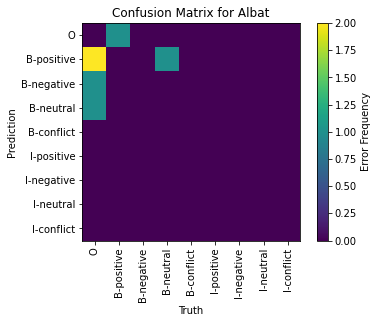

In [9]:
# File path for Albat's E2E MAMS test set predictions (predictions{1,2,3}lc.json)
predictions = "./annotator/predictions1lc.json"

# Directory path containing ground truth labels for MAMS test set (test.json)
# Make sure this is the same dataset used by Albat
truth = "./annotator/"

# Choose a review index to display
review_id = 0

annotator.extractor(review_id,predictions,truth);